In [1]:
import pandas as pd
from pandas import Grouper
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random
from random import sample

In [2]:

#notify me when a long running cell is complete
%load_ext jupyternotify
import time

<IPython.core.display.Javascript object>

In [3]:
content = pd.read_csv('data/movie_titles3.csv', index_col=False, names = ['id', 'year', 'title'])
content.head()

/var/folders/xc/4fn08svj2dgdk_3wj3xkp_rr0000gn/T/ipykernel_18285/3666075594.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  content = pd.read_csv('data/movie_titles3.csv', index_col=False, names = ['id', 'year', 'title'])


,id,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [4]:
content['year'].describe()

count    17763.000000
mean      1990.263694
std         16.507891
min       1896.000000
25%       1985.000000
50%       1997.000000
75%       2002.000000
max       2005.000000
Name: year, dtype: float64

In [5]:
content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      17770 non-null  int64  
 1   year    17763 non-null  float64
 2   title   17770 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 416.6+ KB


# Year Release

There are a few missing years - adding those in.

I'm assuming that people identify heavily with the content that they grew up with or a certain styles of content. For that reason, I'm going to bin films by decade.

However, considering the low outliers anything before 1960 will be binned together. Q1 - 1.5IQR

In [6]:
content[content['year'].isna()]

,id,year,title
4387,4388,NaN,Ancient Civilizations: Rome and Pompeii
4793,4794,NaN,Ancient Civilizations: Land of the Pharaohs
7240,7241,NaN,Ancient Civilizations: Athens and Greece
10781,10782,NaN,Roti Kapada Aur Makaan
15917,15918,NaN,Hote Hote Pyaar Ho Gaya
16677,16678,NaN,Jimmy Hollywood
17666,17667,NaN,Eros Dance Dhamaka


In [7]:
#fix year
content.at[4387,'year']=2002
content.at[4793,'year']=2002
content.at[7240,'year']=2002
content.at[10781,'year']=1974
content.at[15917,'year']=1999
content.at[16677,'year']=1994
content.at[17666,'year']=1999

#check
content[content['year'].isna()]

,id,year,title


In [8]:
def decade(row):
    
    """
    bins years by decade, 1959 and before are binned together
    """
    if row['year'] <= 1959:
        return 0
    elif 1960 <= row['year'] < 1969:
        return 1
    elif 1970 <= row['year'] < 1979:
        return 2
    elif 1980 <= row['year'] < 1989:
        return 3
    elif 1990 <= row['year'] < 1999:
        return 4
    else:
        return 5

In [9]:
#bin years

content['decade'] = content.apply(decade, axis=1)
content

,id,year,title,decade
0,1,2003.0,Dinosaur Planet,5
1,2,2004.0,Isle of Man TT 2004 Review,5
2,3,1997.0,Character,4
3,4,1994.0,Paula Abdul's Get Up & Dance,4
4,5,2004.0,The Rise and Fall of ECW,5
...,...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...,5
17766,17767,2004.0,Fidel Castro: American Experience,5
17767,17768,2000.0,Epoch,5
17768,17769,2003.0,The Company,5


In [10]:
content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      17770 non-null  int64  
 1   year    17770 non-null  float64
 2   title   17770 non-null  object 
 3   decade  17770 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 555.4+ KB


In [11]:
# decade counts
content['decade'].value_counts(sort=True)

decade
5    8457
4    4209
3    1860
0    1246
2    1152
1     846
Name: count, dtype: int64

<BarContainer object of 6 artists>

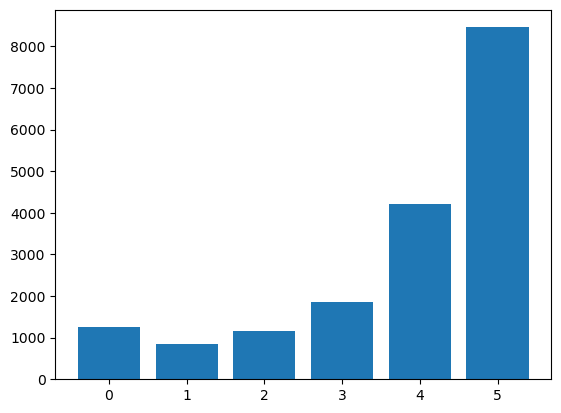

In [12]:
plt.bar((content['decade'].value_counts(sort=True).index), (content['decade'].value_counts(sort=True).values))

# content feature selection

to minimize bias, i'm only going to add the decade column to the data i will use for modeling.

In [13]:
decade = content[['id', 'decade']]
decade = decade.rename(columns = {'id': 'mid', 'decade': 'm_decade'})
decade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   mid       17770 non-null  int64
 1   m_decade  17770 non-null  int64
dtypes: int64(2)
memory usage: 277.8 KB


# ratings

importing partial datasets as csvs for ease of use

In [14]:
d1 = pd.read_csv('data/d1_clean.csv')
d1 = d1.drop(['Unnamed: 0'], axis=1)

d2 = pd.read_csv('data/d2_clean.csv')
d2 = d2.drop(['Unnamed: 0'], axis=1)

d3 = pd.read_csv('data/d3_clean.csv')
d3 = d3.drop(['Unnamed: 0'], axis = 1)

d4 = pd.read_csv('data/d4_clean.csv')
d4 = d4.drop(['Unnamed: 0'], axis =1)

In [15]:
df = pd.concat([d1, d2, d3, d4], axis =0, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 8 columns):
 #   Column   Dtype  
---  ------   -----  
 0   mid      int64  
 1   cust_id  int64  
 2   rating   float64
 3   date     object 
 4   year     int64  
 5   month    int64  
 6   day      int64  
 7   fisc_Q   int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 6.0+ GB


In [16]:
#sanity check: where d1 and d2 end, making sure the index is correct
#mid 9210, cust id 627867, rating 3
df.iloc[51031354]

mid              9210
cust_id        627867
rating            3.0
date       2005-05-02
year             2005
month               5
day                 2
fisc_Q              2
Name: 51031354, dtype: object

In [46]:
%notify

<IPython.core.display.Javascript object>

In [17]:
df = df.sample(n=50000000, random_state=1)

In [18]:
%notify

<IPython.core.display.Javascript object>

In [19]:
df.head()

,mid,cust_id,rating,date,year,month,day,fisc_Q
66892855,12221,2380329,4.0,2004-11-05,2004,11,5,4
68718197,12473,1340872,3.0,2003-05-16,2003,5,16,2
26523041,4943,2552315,3.0,2002-02-21,2002,2,21,1
8709708,1744,1728377,4.0,2003-02-20,2003,2,20,1
66709759,12181,2275381,3.0,2004-08-27,2004,8,27,3


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000000 entries, 66892855 to 98785310
Data columns (total 8 columns):
 #   Column   Dtype  
---  ------   -----  
 0   mid      int64  
 1   cust_id  int64  
 2   rating   float64
 3   date     object 
 4   year     int64  
 5   month    int64  
 6   day      int64  
 7   fisc_Q   int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 3.4+ GB


In [21]:
#dropping day and month because i changed my mind
df = df.drop(['day', 'month', 'fisc_Q', 'year'], axis=1)

In [22]:
#rename columns to avoid 'm_decade' confusion
df = df.rename(columns = {'date': 'r_date'})
df.head()

,mid,cust_id,rating,r_date
66892855,12221,2380329,4.0,2004-11-05
68718197,12473,1340872,3.0,2003-05-16
26523041,4943,2552315,3.0,2002-02-21
8709708,1744,1728377,4.0,2003-02-20
66709759,12181,2275381,3.0,2004-08-27


In [53]:
df['r_date'] = df['r_date'].astype('datetime64[ns]')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 66892855 to 8511746
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype         
---  ------   --------------    -----         
 0   mid      1000000 non-null  int64         
 1   cust_id  1000000 non-null  int64         
 2   rating   1000000 non-null  float64       
 3   r_date   1000000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 38.1 MB


In [54]:
df = df.sort_values(by=['r_date'])
df

,mid,cust_id,rating,r_date
16070838,3113,510180,3.0,1999-12-12
15389684,2953,510180,5.0,1999-12-16
61711419,11242,830363,3.0,1999-12-21
46278330,8327,1435350,5.0,1999-12-27
55472684,10152,1435350,5.0,1999-12-27
...,...,...,...,...
8137925,1629,2190800,2.0,2005-12-31
19205037,3643,125392,4.0,2005-12-31
52088122,9458,1992864,5.0,2005-12-31
59741404,10986,1784540,3.0,2005-12-31


In [23]:
df['mid'].value_counts()

mid
5317     116299
15124    107748
14313     99457
15205     98021
1905      96451
          ...  
8146          7
11344         5
6256          5
13755         2
11148         2
Name: count, Length: 17770, dtype: int64

In [24]:
type(df)

pandas.core.frame.DataFrame

In [25]:
data = df.merge(decade)
data.head()

,mid,cust_id,rating,r_date,m_decade
0,12221,2380329,4.0,2004-11-05,3
1,12221,836701,5.0,2004-08-27,3
2,12221,190111,2.0,2005-10-10,3
3,12221,279477,5.0,2004-07-17,3
4,12221,1046137,4.0,2002-10-01,3


In [26]:
data['mid'].value_counts()

mid
5317     116299
15124    107748
14313     99457
15205     98021
1905      96451
          ...  
8146          7
11344         5
6256          5
13755         2
11148         2
Name: count, Length: 17770, dtype: int64

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000000 entries, 0 to 49999999
Data columns (total 5 columns):
 #   Column    Dtype  
---  ------    -----  
 0   mid       int64  
 1   cust_id   int64  
 2   rating    float64
 3   r_date    object 
 4   m_decade  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.9+ GB


In [28]:
#data.to_csv('data/50mdf.csv', index=False)

# Ready for EDA

In [62]:
data.head()

,mid,cust_id,rating,r_date,m_decade
0,3113,510180,3.0,1999-12-12,4
1,3113,1589382,4.0,2000-03-11,4
2,3113,1878798,2.0,2000-08-08,4
3,3113,1259176,4.0,2000-11-10,4
4,3113,873369,3.0,2000-11-20,4


## Exploring content attributes

- highest rated content (content quality)
- most rated content (popularity)
- decade frequency distribution

### Decade Frequency Distribution

<BarContainer object of 6 artists>

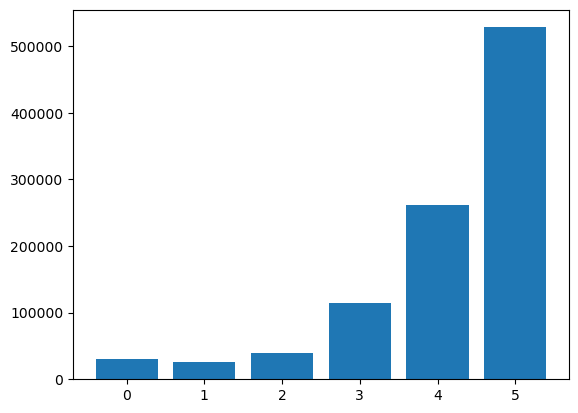

In [64]:
plt.bar((data['m_decade'].value_counts(sort=True).index), (data['m_decade'].value_counts(sort=True).values))

In [66]:
data['m_decade'].value_counts(normalize=True)

m_decade
5    0.528246
4    0.261975
3    0.113831
2    0.039405
0    0.030192
1    0.026351
Name: proportion, dtype: float64

### Looking at rating as a popularity metric - speaks to the perceived quality of the content

In [67]:
#average rating for each content piece
avgrating = data.groupby('mid')['rating'].mean().sort_values(ascending=False).to_frame()
avgrating = avgrating.rename(columns = {'rating': 'm_avg_rating'}).reset_index()
avgrating

,mid,m_avg_rating
0,12972,5.0
1,9158,5.0
2,9162,5.0
3,9173,5.0
4,2648,5.0
...,...,...
16216,17284,1.0
16217,16549,1.0
16218,6496,1.0
16219,16073,1.0


**1. What is the distribution of content ratings?**

In [68]:
avgrating['m_avg_rating'].describe()

count    16221.000000
mean         3.263065
std          0.787667
min          1.000000
25%          2.947368
50%          3.333333
75%          3.800000
max          5.000000
Name: m_avg_rating, dtype: float64

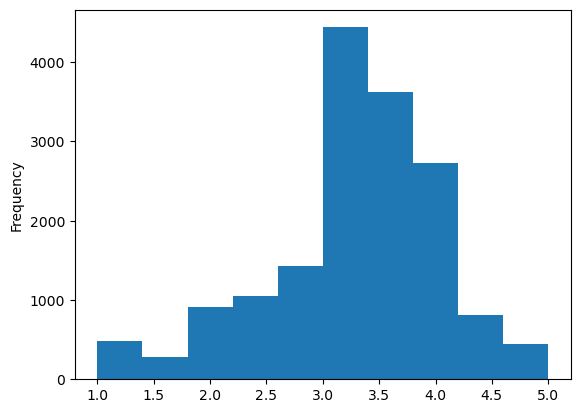

In [69]:
#looks at distribution of avg rating per movie
avgrating['m_avg_rating'].plot(kind='hist');

Skewed to the left. Users tend to rate content above average. 

Binning based on average rating. This doesn't necessarily speak to the quality of the content however it does show that our users tend to enjoy it. I'll be labeling this feature quality for ease of use, but ***note that this is a metric solely simplifying how users perceive the piece of content's quality compared to other options that are available.***

In [70]:
#distribution is pretty normal, going to bin into 'quality grade' quartiles

def quality(row):
    """
    bins content based on their average ratings
    """
    if row['m_avg_rating'] < 2.9:
        return 1
    elif 2.9 <= row['m_avg_rating'] < 3.3:
        return 2
    elif 3.3 <= row['m_avg_rating'] < 3.7:
        return 3
    else:
        return 4

In [71]:
avgrating['m_quality'] = avgrating.apply(quality, axis=1)
avgrating

,mid,m_avg_rating,m_quality
0,12972,5.0,4
1,9158,5.0,4
2,9162,5.0,4
3,9173,5.0,4
4,2648,5.0,4
...,...,...,...
16216,17284,1.0,1
16217,16549,1.0,1
16218,6496,1.0,1
16219,16073,1.0,1


In [72]:
#adding quality and avg rating as a feature
data = data.merge(avgrating)
data.head()

,mid,cust_id,rating,r_date,m_decade,m_avg_rating,m_quality
0,3113,510180,3.0,1999-12-12,4,3.187192,2
1,3113,1589382,4.0,2000-03-11,4,3.187192,2
2,3113,1878798,2.0,2000-08-08,4,3.187192,2
3,3113,1259176,4.0,2000-11-10,4,3.187192,2
4,3113,873369,3.0,2000-11-20,4,3.187192,2


**2. On average, do users enjoy a specific decade more than others?**

<AxesSubplot:xlabel='m_decade', ylabel='m_avg_rating'>

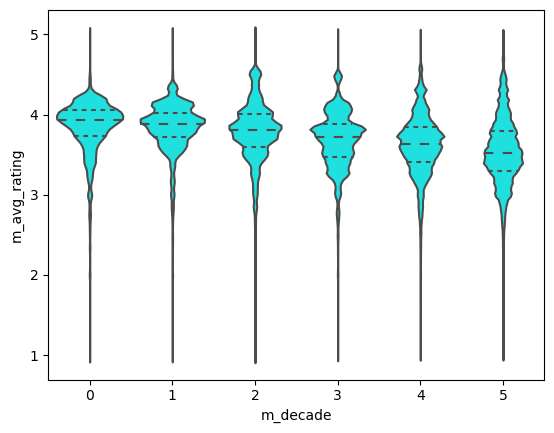

In [73]:
sns.violinplot(
    y="m_avg_rating", 
    x="m_decade", 
    data=data, 
    color='aqua',
    inner="quartile",  # Seeing the mean and quartiles
)


In [74]:
data.groupby('m_decade')['rating'].mean().sort_values(ascending=False)

m_decade
0    3.849364
1    3.836780
2    3.774851
3    3.681291
4    3.623350
5    3.542565
Name: rating, dtype: float64

On average, users may tend to rate older content slightly higher.

**3. What is the distribution of rating count? Does higher rating count indicate higher quality?**

In [76]:
popularity = data.groupby('mid')['rating'].count().sort_values(ascending=False).to_frame()
popularity = popularity.rename(columns = {'rating': 'r_count'}).reset_index()
avgrating = avgrating.merge(popularity)
avgrating.describe()

,mid,m_avg_rating,m_quality,r_count
count,16221.000000,16221.000000,16221.000000,16221.000000
mean,8889.624499,3.263065,2.586030,61.648480
std,5138.947282,0.787667,1.150167,175.357348
min,1.000000,1.000000,1.000000,1.000000
25%,4439.000000,2.947368,2.000000,2.000000
50%,8878.000000,3.333333,3.000000,7.000000
75%,13346.000000,3.800000,4.000000,32.000000
max,17770.000000,5.000000,4.000000,2269.000000


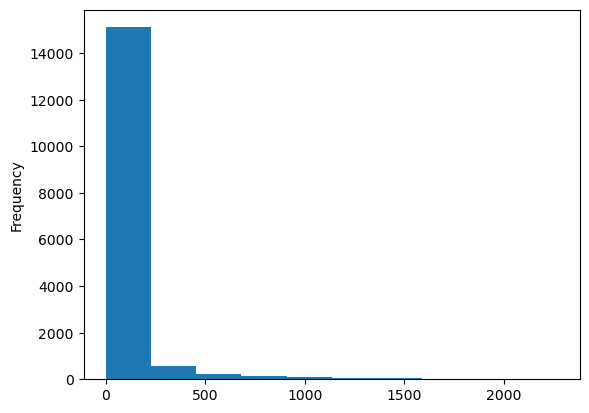

In [77]:
#looks at distribution of rating count per content
avgrating['r_count'].plot(kind='hist');

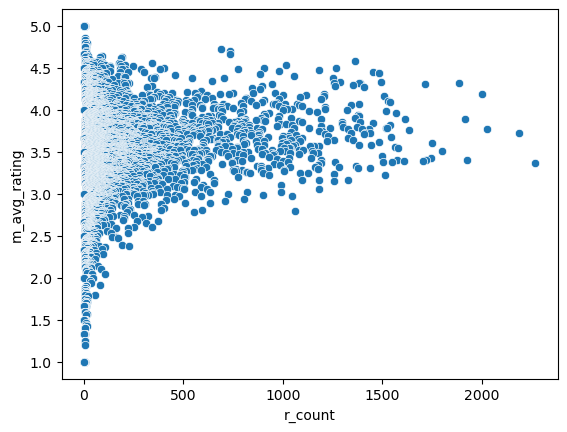

In [78]:
sns.scatterplot(x=avgrating['r_count'],y=avgrating['m_avg_rating']);

<AxesSubplot:xlabel='r_count', ylabel='m_avg_rating'>

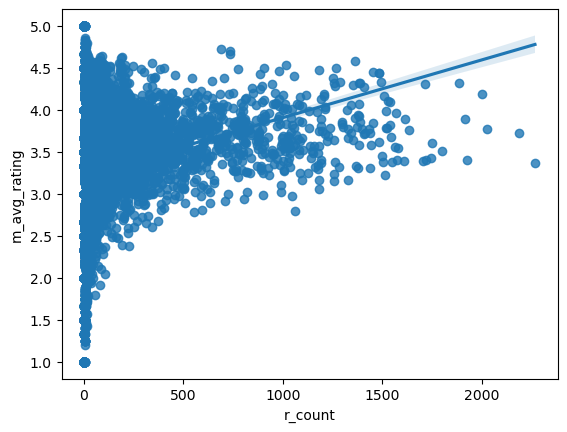

In [79]:
sns.regplot(data = avgrating, x='r_count', y='m_avg_rating')

### Thoughts on content attributes

- Popularity: content pieces on avg have 12 ratings, though it can range up to 4606 ratings. More popular content has an above average rating. I'll address popularity bias in my models

- Quality: I'm certain that quality directly impacts consumer experience so I made it a feature I'd like to keep an eye on

- Decade: grouping by decade rather than year released is more meaningful in that it also describes potential stylistic preferences or nostalgia/emotional attachments


## User behavior

**1. Most active users**

In [ ]:
users = data.groupby('cust_id')['rating'].count().sort_values(ascending=False).to_frame()
users = users.rename(columns = {'rating': 'user_engagement'}).reset_index()
users.describe()

In [ ]:
#looks at distribution of avg # of ratings per user
users['user_engagement'].plot(kind='hist');

In [ ]:
def activity(row):
    
    """
    bins users by activity level
    """
    if row['user_engagement'] == 1:
        return 1
    elif row['user_engagement'] == 2:
        return 2
    elif 3 <= row['user_engagement'] <= 4:
        return 3
    elif 5 <= row['user_engagement'] <= 10:
        return 4
    else:
        #these are super users
        return 5

In [ ]:
users['cust_act_rank'] = users.apply(activity, axis=1)
users.head()

In [ ]:
users['cust_act_rank'].value_counts() 

In [ ]:
plt.bar((users['cust_act_rank'].value_counts(sort=True).index), 
        (users['cust_act_rank'].value_counts(sort=True).values))

In [ ]:
data.head()

In [ ]:
data.to_csv('data/final_df.csv')

In [ ]:
series = data[['r_date', 'rating']]

In [ ]:
series['Month_Year'] = series['r_date'].dt.to_period('M')


In [ ]:
series_my = series.groupby('Month_Year')['rating'].count().sort_values(ascending=False).to_frame()
series_my.head()

In [ ]:
series_my.info()

In [ ]:
series_my.plot(figsize = (16,6));

In [ ]:
year_groups = series_my.groupby(pd.Grouper(freq='A'))
year_groups.head()

In [ ]:
series_my_df = pd.DataFrame()

for yr, group in year_groups:
    series_my_df[yr.year] = group.values.ravel()
    
series_my_df.plot(subplots=True, legend=True)